# PV254 Recommender Systems
## News reccomendation

For this consultation, you should have:

- problem formulation, usage, hypothetical business model, ...
- specific data with some basic analysis (value distributions etc)
- specific proposal for algorithms that you want to implement
- implementation of some naive baseline
- basic idea of evaluation approach

### Problem formulation & usage 
Application - recommending news articles with UI

#### Where will the recommendations happen
1. User will land on a Home page, where popular articles will be recommended
2. While on an article page, the User will see recommended articles based on the current article and other aspects (popular, category, what he likes, ...)
3. User could choose what categories he likes most. E.g. sports, politcs, etc. (could be nice for cold-start problem)

### Bussines model
The page could generate revenue through clicks, ads, sponsored content, donations, etc.
1. Own portal
    - all articles are made by 'our' news portal
    - revenue is made through ads and subscriptions
2. MSN like portal (reccomending articles of other news portals)
    - mix own 'own' articles and articles of popular news portals (DW, iDnes, Denník N, ...)
    - revenue is made thorugh ads and clicks from our portal to the given news portal (PPC)

### The Dataset
We are using the <a href="https://www.kaggle.com/datasets/arashnic/mind-news-dataset/data">MIND</a> dataset collected from the Microsoft News website. More specificially we will be working with the **Mind-small** version with data from 50k users.\
The dataset structure is explained <a href="https://github.com/msnews/msnews.github.io/blob/master/assets/doc/introduction.md">here</a>.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import matplotlib_inline


In [2]:
# run python -m nbconvert --to html --no-input .\project.ipynb
# to create the markdown html without code snippets

%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg', 'pdf')
pio.renderers.default='notebook'

data = pd.read_csv('../dataset/news.tsv', header=None, sep='\t', usecols=[0, 1, 2, 3, 4])

data.columns = ['ID',
                "Category",
                "SubCategory",
                "Title",
                "Abstract"]

# Data Preprocessing
old_len = len(data)
data.drop_duplicates(subset=['Title'],inplace=True)
print('The number of dropped duplicate article Titles:', old_len - len(data))
data_articles = data
number_of_articles = len(data)
unique_categories = data['Category'].nunique()
unique_subcategories = data['SubCategory'].nunique()

The number of dropped duplicate article Titles: 848


In [3]:
data_users = pd.read_csv('../dataset/behaviors.tsv', header=None, sep='\t', usecols=[0, 1])

data_users.columns = ['ID', "User_ID"]

no_of_behaviors = len(data_users)
no_of_users = data_users['User_ID'].nunique()

In [4]:
# Calculate the length of titles
title_word_counts = data['Title'].apply(lambda x: len(x.split()))
avg_title_words = np.average(title_word_counts)
title_lengths = data['Title'].apply(len)
avg_title_len = np.average(title_lengths)

print("Data length before Na drop: ", len(data))
data.dropna(inplace=True)
print("Data length after Na drop: ", len(data))
abstract_word_counts = data['Abstract'].apply(lambda x: len(x.split()))
avg_abstract_len = np.average(abstract_word_counts)

Data length before Na drop:  50434
Data length after Na drop:  47788


### Value distributions

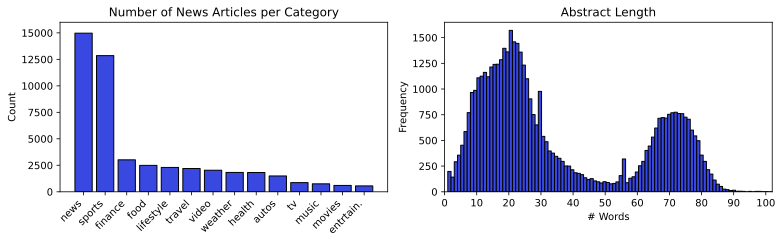

In [19]:
c = data['Category'].value_counts()
c = c[c >= 100]

c.index = c.index.where(c.index != 'foodanddrink', 'food')
c.index = c.index.where(c.index != 'entertainment', 'entrtain.')

# Plot the bar chart
plt.figure(figsize=(11, 3.5))

plt.subplot(1, 2, 1)  # (rows, columns, panel number)
plt.bar(c.index, c.values, color='#3848e0', edgecolor='black')
plt.ylabel('Count')
plt.title('Number of News Articles per Category')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.ylim(0, 16001)

# Plot the histogram
plt.subplot(1, 2, 2)  # (rows, columns, panel number)
plt.hist(abstract_word_counts, bins=470, color='#3848e0', edgecolor='black')
plt.xlabel('# Words')
plt.ylabel('Frequency')
plt.title('Abstract Length')
plt.xticks(range(0, 101, 10))  # Set x-ticks
plt.xlim(0, 102)

plt.tight_layout()
plt.savefig("output1.svg")
plt.show()


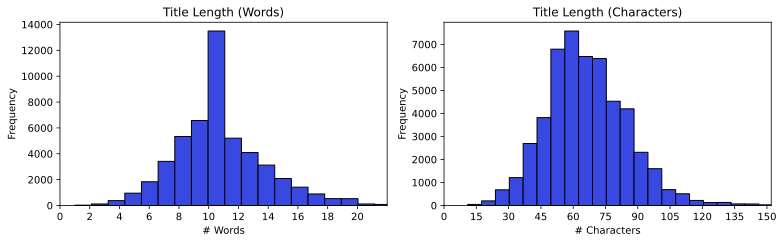

In [20]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(11, 3.5))

# Plot histogram for number of words
axes[0].hist(title_word_counts, bins=50, color='#3848e0', edgecolor='black')
axes[0].set_xlabel('# Words')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Title Length (Words)')
axes[0].set_xticks(range(0, 21, 2))  # Set x-ticks
axes[0].set_xlim(0, 22)  # Limit x-axis up to 20

# Plot histogram for number of characters
axes[1].hist(title_lengths, bins=50, color='#3848e0', edgecolor='black')
axes[1].set_xlabel('# Characters')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Title Length (Characters)')
axes[1].set_xticks(range(0, 151, 15))  # Set x-ticks
axes[1].set_xlim(0, 152)  # Limit x-axis up to 150

plt.tight_layout()
plt.savefig("output2.svg")
plt.show()

In [21]:
# DataFrame from the calculated values
summary_data = pd.DataFrame({
    'Metric': ['# News articles', '# Users', '# User behaviors', 'Unique Categories', 'Unique Subcategories', 'Average Title Length (Words)', 'Average Title Length (Characters)', 'Average Abstract Length (Words)'],
    'Value': [number_of_articles, no_of_users, no_of_behaviors, unique_categories, unique_subcategories+19, round(avg_title_words, 2), round(avg_title_len, 2), round(avg_abstract_len, 2)]
})

# Markdown table generator
from IPython.display import Markdown, display
display(Markdown(summary_data.to_markdown(index=False)))

| Metric                            |     Value |
|:----------------------------------|----------:|
| # News articles                   |  50434    |
| # Users                           |  50000    |
| # User behaviors                  | 156965    |
| Unique Categories                 |     17    |
| Unique Subcategories              |    282    |
| Average Title Length (Words)      |     10.78 |
| Average Title Length (Characters) |     66.37 |
| Average Abstract Length (Words)   |     36.29 |



The authors of the original article [MIND: A Large-scale Dataset for News Recommendation](https://aclanthology.org/2020.acl-main.331) (Wu et al., ACL 2020)  show that most (84.5%) of articles have survival time of less than two days.

### Proposal of algorithms


- **TF-IDF** + **Cosine similiarity** | **Euclidean distance** | **Jaccard coefficient** 
- **Taxonomy??**
- **kNN** on categories, 17 clusters, 263 subclusters
- embeddings computed by TransE method in *entity_embdedding.vec* and *relation_embedding.vec*


### Naive baseline implementation

1. History => reccomended article (according to category/subcategory) - green column **article_id**
    - in = user_id
    - out = reccomended articles
2. Popular in last 24h - orange column **articled_id-0/1**


#### DEMO


In [2]:
from importlib import reload
import web.algorithms.naive_rec as naive_rec

reload(naive_rec)

pop_articles = naive_rec.example()

from IPython.display import Markdown, display
display(Markdown(pop_articles.to_markdown(index=False)))

Top 5 Most Popular Clicked Articles within 24 hours before 11/14/2019 12:26:47 PM :
N23446    1782
N38779    1286
N56214    1154
N4642      818
N51048     748
dtype: int64
------------------------------------------------------------------------------------------------------------------------
Top 5 most popular categories for user U81540 : ['news', 'lifestyle', 'entertainment', 'health', 'finance']
Top 5 most popular subcategories for user U81540 : ['newsopinion', 'humor', 'lifestylebuzz', 'newspolitics', 'newscrime']
Selected category articles for user U81540 : {'news': ['N42864', 'N40817', 'N13925', 'N17067', 'N42088'], 'lifestyle': ['N37841', 'N22036', 'N32638', 'N29988', 'N6850'], 'entertainment': ['N47933', 'N5391', 'N50372', 'N20536', 'N54544'], 'health': ['N55870', 'N16869', 'N7945', 'N6001', 'N10982'], 'finance': ['N58716', 'N54647', 'N34283', 'N11801', 'N24761']}
Selected subcategory articles for user U81540 : {'newsopinion': ['N63697', 'N7780', 'N37936', 'N55701', 'N47020'], '

| ID     | Category   | Subcategory       | Headline                                                                                                                                        |
|:-------|:-----------|:------------------|:------------------------------------------------------------------------------------------------------------------------------------------------|
| N4642  | music      | music-celebrity   | Kodak Black Sentenced to Over 3 Years in Prison in Weapons Case                                                                                 |
| N23446 | lifestyle  | lifestyleroyals   | Prince Harry and Meghan Markle just shared a never-before-seen photo of baby Archie with his 'Grandpa' Prince Charles to celebrate his birthday |
| N51048 | news       | elections-2020-us | Rep. Tim Ryan endorses Biden in Democratic primary                                                                                              |
| N56214 | weather    | weathertopstories | Deadly Arctic blast breaks records set more than 100 years ago                                                                                  |
| N38779 | news       | newsus            | 'One in a million' deer captured on camera in Michigan woods                                                                                    |

### TF-IDF

According to the [MIND](https://aclanthology.org/2020.acl-main.331.pdf) article, the Title ranks second in metrics among the Title, Abstract, and Body; however, the difference in effectiveness between the title and the body is so marginal that it's practically negligible (AUC of  66.22 vs. 66.32).

In [11]:
import web.algorithms.tf_idf as tf_idf
import warnings
from IPython.display import Markdown, display
warnings.filterwarnings('ignore')

rec_articles_ids = tf_idf.tf_idf_cosine_rec(data_articles, 'sports', 'PGA Tour winners')
tf_idf_articles = data_articles[data_articles['ID'].isin(rec_articles_ids)]

display(Markdown(tf_idf_articles.to_markdown(index=False)))

| ID     | Category   | SubCategory   | Title                                                        | Abstract                                                                                                                                                                                                  |
|:-------|:-----------|:--------------|:-------------------------------------------------------------|:----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| N46502 | sports     | golf          | 2019-20 PGA Tour tournament winners                          | Check out all the winners on the PGA Tour in the 2019-20 season.                                                                                                                                          |
| N8997  | sports     | golf          | Tiger Woods' 82 PGA Tour wins by the numbers                 | A closer look at how Tiger Woods got to 82 career PGA Tour wins, tying Sam Snead's longstanding record.                                                                                                   |
| N27790 | sports     | golf          | Tiger Woods' milestone PGA Tour wins                         | Landmark victories for Tiger Woods in his march to 82 Related: Using the 'Sam Snead criteria', Tiger actually has 95 career wins                                                                          |
| N46089 | sports     | golf          | PGA Tour hopes to 'never leave Japan'                        | INZAI CITY, Japan (AP) Joining forces with a celebrity tycoon who dreams of going to the moon, the PGA Tour is committed to being in Japan for the long haul with its first tournament starting Thursday. |
| N28661 | sports     | golf          | The 9 'quiet' winners of the PGA Tour's fall season (so far) | Big names have carried much of the PGA Tour's fall season, but these men who have flown under the radar and put themselves in prime position for 2020                                                     |

### Basic idea of evaluation
**AUC**, MRR and nDCG@k\
Training set, Test set

#### DEMO

Concat article titles

In [1]:
from web.algorithms.evaluator import Evaluator
import web.algorithms.tf_idf_recommender as tf_idf
import warnings
warnings.filterwarnings('ignore')
from importlib import reload

reload(tf_idf)

eval = Evaluator()

# print(eval.evaluate(get_coeficcients_most_popular))
output = eval.evaluate(tf_idf.tf_idf_cosine_recommender)
formatted_output = {
    'group_auc': round(output[0], 4),
    'mean_mrr': round(output[1], 4),
    'ndcg@5': round(output[2], 4),
    'ndcg@10': round(output[3], 4)
}

print(formatted_output)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pewdi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pewdi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pewdi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


CONCAT
{'group_auc': 0.5579, 'mean_mrr': 0.2924, 'ndcg@5': 0.3182, 'ndcg@10': 0.3761}


Split article titles (100 behaviors)

In [5]:
from web.algorithms.evaluator import Evaluator
import web.algorithms.tf_idf_recommender as tf_idf
import warnings
warnings.filterwarnings('ignore')
from importlib import reload

reload(tf_idf)

eval = Evaluator()

# print(eval.evaluate(get_coeficcients_most_popular))
output = eval.evaluate(tf_idf.tf_idf_cosine_recommender)
formatted_output = {
    'group_auc': round(output[0], 4),
    'mean_mrr': round(output[1], 4),
    'ndcg@5': round(output[2], 4),
    'ndcg@10': round(output[3], 4)
}

print(formatted_output)

SPLIT
{'group_auc': 0.563, 'mean_mrr': 0.3081, 'ndcg@5': 0.33, 'ndcg@10': 0.3854}


Similiar categories + most_popular method (top 100)

In [4]:
from web.algorithms.evaluator import Evaluator
import web.algorithms.similiar_category_combinations as sim_cat_combs
import warnings
warnings.filterwarnings('ignore')
from importlib import reload

reload(sim_cat_combs)

eval = Evaluator()

# print(eval.evaluate(get_coeficcients_most_popular))
output = eval.evaluate(sim_cat_combs.sim_cat_rec)
formatted_output = {
    'group_auc': round(output[0], 4),
    'mean_mrr': round(output[1], 4),
    'ndcg@5': round(output[2], 4),
    'ndcg@10': round(output[3], 4)
}

print(formatted_output)

Dictionary loaded successfully from file:  datasets/category_sims/news.txt
Dictionary loaded successfully from file:  datasets/category_sims/entertainment.txt
Dictionary loaded successfully from file:  datasets/category_sims/lifestyle.txt
{'group_auc': 0.5399, 'mean_mrr': 0.272, 'ndcg@5': 0.266, 'ndcg@10': 0.3265}
